In [17]:
import lightgbm as lgb
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [5]:
if 'ygong' in os.getcwd():
    filepath = "../data"
    dir_out = "../output"
else:
    filepath = "/home/gong/Documents/Kaggle_July2019/data"
    dir_out = "/home/gong/Documents/Kaggle_July2019/output"

In [20]:
def prepare_train():
    data = pd.read_csv(os.path.join(dir_out, '_train_0730.csv'))
    data_submit = pd.read_csv(os.path.join(dir_out, '_test_0730.csv'))
    #Get only 10% of dataset for fast evaluation!
#     size = round(0.10 * data.shape[0])
#     data = data[:size]
    print('Train dataset shape is now rows: {} cols:{}'.format(data.shape[0], data.shape[1]))
    X = data.drop(columns=['scalar_coupling_constant'])
    y = data['scalar_coupling_constant']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    return X_train, X_test, y_train, y_test, data_submit

Train dataset shape is now rows: 4658147 cols:18
Train score: 0.9885959670567054
Test score: 0.9884852422685836


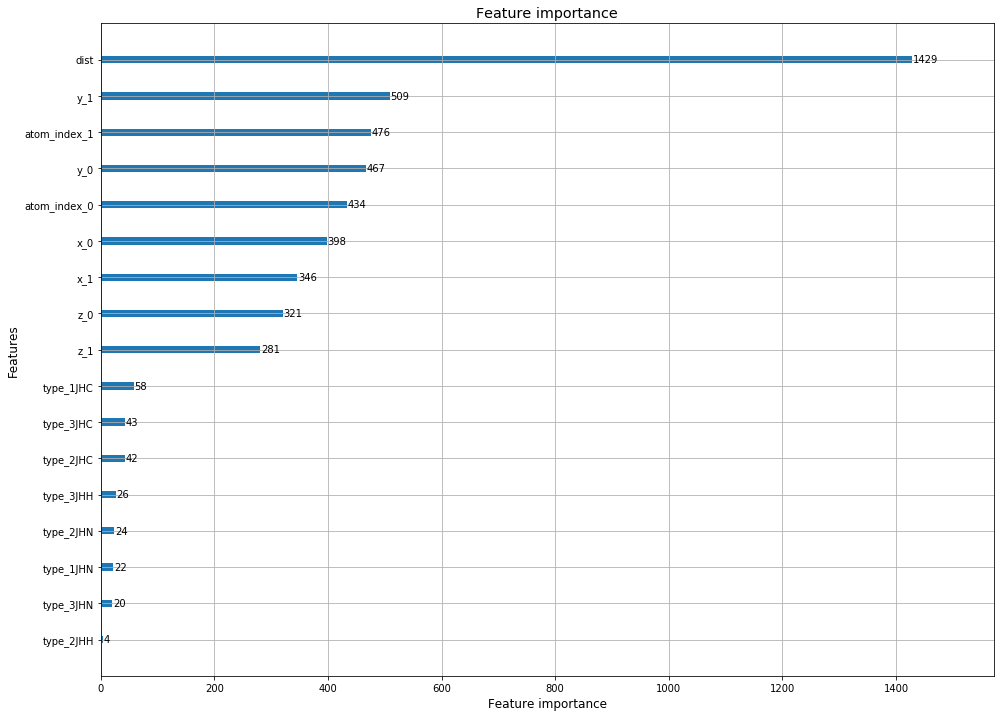

The mean absolute deviation is 0.854010146391342


In [21]:
X_train, X_test, y_train, y_test, test_submit = prepare_train()

params = {'num_leaves': 50,
          'min_child_samples': 79,
          'min_data_in_leaf': 100,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0,
         }

reg_model = lgb.LGBMRegressor(**params)
reg_model.fit(X_train, y_train)
y_predict = reg_model.predict(X_test)
print('Train score: {}'.format(reg_model.score(X_train, y_train)))
print('Test score: {}'.format(reg_model.score(X_test, y_test)))

fig, axes = plt.subplots()
fig.set_size_inches(16, 12)
lgb.plot_importance(reg_model, ax=axes)
plt.show()

# print MAE
error = mean_absolute_error(y_test, y_predict)
print('The mean absolute deviation is {}'.format(np.log(error)))

In [22]:
y_predict_lgb = reg_model.predict(test_submit)
submit = pd.read_csv(os.path.join(filepath, 'sample_submission.csv')).drop(columns='scalar_coupling_constant')
submit['scalar_coupling_constant'] = y_predict_lgb
submit.to_csv(os.path.join(dir_out, 'submission.csv'), index=False)

In [27]:
import subprocess
#subprocess.check_output(['ls','-l']) #all that is technically needed...
print(subprocess.check_output(['pwd']))
subprocess.call(['sh', './submit.sh'])

b'/home/ygong/Documents/Kaggle_July2019/code\n'


0